<a href="https://colab.research.google.com/github/kevinroccapriore/STEM-notebooks/blob/main/Particle_Tracking_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9.29.2020

This notebook tracks particle motion in energy space (which should *not* occur) by finding all particle centers in each specified energy slice. This was designed for the purpose of correcting the so-called bumponium artifact arising in monochromated EELS, due to the monochromator slit imposing additional energy loss.

1. Import all the libraries necessary to work with the EELS data. Similar to the EELS notebooks.

In [1]:
#@title Import modules
from tqdm import tqdm_notebook
from tqdm import tqdm
from pylab import cm
from scipy import interpolate
from scipy.ndimage import gaussian_filter
import glob
import os
import string
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import json
from pylab import cm
from scipy import interpolate
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from scipy import ndimage
from scipy import signal
import operator
from skimage.filters import sobel
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from google.colab.patches import cv2_imshow
from PIL import Image
import imutils
from skimage.transform import resize

# Machine learning modules
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

from skimage.draw import polygon2mask
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Rectangle
from skimage import feature
from skimage.measure import profile_line
# from skimage.feature import blob_log

# <UNUSED> Interactivity modules <UNUSED>
# import chart_studio.plotly as py
# from plotly.offline import init_notebook_mode, iplot
# from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

In [4]:
#@title Define functions
  
def organize_data(filename, plot = False):
  SIraw, XY, disp, SIraw_flat = OrganizeInput(filename) 
  SInc = CorrectNeg(SIraw, Blur = 20, Neg = -20, Pixrange = 200, plot = plot)
  SIncflat = SInc.reshape((np.prod(XY),SInc.shape[2]))
  EnergyAxes=CalibrateEnergyAxis(SInc,disp)                  # align ZLP & use dispersion to go from pixel -> eV
  Eaxflat=EnergyAxes.reshape((np.prod(XY),SInc.shape[2]))    # flatten
  E,SI=CalibrateSI(EnergyAxes,SInc, N = 5000)                # calibrate energies by making all pixels start and end at same energy values
  SIflat=SI.reshape((np.prod(XY),SI.shape[2]))  
  return E, SI, XY, SIflat

def truncate_spectrum(ENB, cutoffenergy):
  truncate = (np.abs(ENB-cutoffenergy)).argmin()
  return truncate 

def OrganizeInput(numpy):
    SIraw = np.load(numpy)
    XY = SIraw.shape[:2]
    SIj = json.load(open(numpy[:-3]+'json','r'))
    disp = SIj['spatial_calibrations'][2]['scale']
    SIraw_flat=SIraw.reshape((np.prod(XY),SIraw.shape[2]))
    return SIraw, XY, disp, SIraw_flat
    
def LoadADF(filename):
    ADF1    = np.load(filename)
    ADF1j = json.load(open(filename[:-3]+'json','r'))
    ADF1_scale = ADF1j['spatial_calibrations'][0]['scale']
    return ADF1, ADF1_scale

def CalibrateEnergyAxis(SI,disp,style='fwhm',subfitwidth=8):
    Einit=np.arange(0,SI.shape[2])*disp
    if style=='pixel': ZLPC=np.array([[Einit[np.argmax(s)] for s in row] for row in SI])
    if style=='fwhm':
        lh,uh=[],[]
        avspec=np.average(SI,axis=(0,1))
        for row in SI:
            lh.append([]);uh.append([])
            for s in row:
                if np.amax(s)<1000: # This line is for thick samples when ZLP drops to noise levels
                    s=avspec
                lh[-1].append(Einit[np.argmin(np.abs(s[:np.argmax(s)]/np.amax(s)-0.5))])
                uh[-1].append(Einit[np.argmin(np.abs(s[np.argmax(s):]/np.amax(s)-0.5))+np.argmax(s)])
        lh=np.asarray(lh)        
        uh=np.asarray(uh)
        ZLPC=np.average([uh,lh],axis=0)
    if style=='subpixel':
        def gauss(x,a,x0,s): return a*np.exp(-(x-x0)**2/s**2)
        from scipy.optimize import curve_fit
        ZLPC=np.array([[curve_fit(gauss,Einit[np.argmax(s)-W:np.argmax(s)+W],
                               s[np.argmax(s)-W:np.argmax(s)+W]/np.amax(s))[0][1] for s in row] for row in SI])
    return np.array([[Einit-c for c in row] for row in ZLPC])
    
def CalibrateSI(EAx,SI,N=5000):
    m,M = np.amax(np.amin(EAx,axis=(2))), np.amin(np.amax(EAx,axis=(2)))
    Eout=np.linspace(m,M,N)[1:]
    Eout=np.linspace(m,M,N,endpoint=True)
    SIout=np.array([[interpolate.interp1d(e,s)(Eout) for e,s in zip(erow,srow)] for erow,srow in zip(EAx,SI)])
    return Eout,SIout


def normalize(image):
  return (image - np.min(image))/(np.ptp(image))
# Interactivity functions

# plotly

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))
  
# Bokeh instead maybe better for clicking?

In [3]:
#@title Download files to workspace
%%capture

# !gdown https://drive.google.com/uc?id=1Kdb8JtCwCCqC2vBOaql1D-KG-s9jmtMC  # single sphere wide fov
# !gdown https://drive.google.com/uc?id=1qDciRh0vc--CmDETw7W883sOtbZotNaS  # single sphere wide fov

# !gdown https://drive.google.com/uc?id=15AydBYrXkq1gfF1WKuxnj-hEwVFITace  # single cube
# !gdown https://drive.google.com/uc?id=17b5hPxT4u79GPDTfCoigkyiFShPsbrxd  # single cube

!gdown https://drive.google.com/uc?id=1sbBZqGaoiZ2ILum162URJyDqyMnINSG9 # Jordan hexagon arrangement
!gdown https://drive.google.com/uc?id=1vSfU6_mW4AapwLiHeV9bHrT2sI-bgWSv # Jordan hexagon arragement

Alternatively, import your own file (currently works for *.npy files):

In [4]:
# from google.colab import files
# uploaded = files.upload()

# Preview `raw` data 
* Done by averaging across <u>entire</u> spectrum in each pixel
* ZLP is orders of magnitude stronger than everything else
* therefore, these images will mostly be maps of the ZLP, which is close to (but not the same as) the ADF map


SI5_Aligned_SI.npy
Dimensions: (120, 120, 2048)


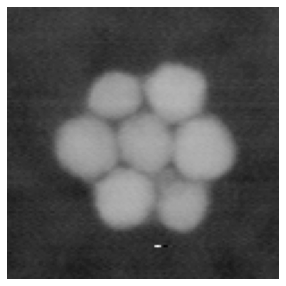

In [5]:
filelist_ = glob.glob('*.npy')
metadatalist_ = glob.glob('*.json')

filelist = sorted(filelist_)
metadatalist = sorted(metadatalist_)

for ii in range(len(filelist)):
  plt.figure(figsize = (5,5))
  im = np.load(filelist[ii])
  print("\n" + filelist[ii]+ "\nDimensions: {}".format(im.shape))
  if np.ndim(im) == 2:  # these are all 3 dimensional so this should be ignored
      plt.imshow(im, origin='lower', cmap = 'gray')
  elif np.ndim(im) == 3:
      plt.imshow(np.mean(im[:,:,:],axis=2), origin='lower', cmap = 'gray_r')
      plt.axis('off')
  plt.show()

**<font color = 'crimson'>Organize the data</font>**:

Links dispersion to each dataset to get proper energy units, and primarily generates the spectrum image and energy parameters needed for further analysis
* `SI` is the 3-dim array, with axes: (X, Y, energy)
* `E` is the (calibrated) energy axis for SI
* `XY` is the product of X and Y axes (for flattening)
* `SIflat` is just the spatially flattened version of SI

In [6]:
E_list = []
SI_list = []
XY_list = []
SIflat_list = []

for ii in range(len(filelist)):
  E, SI, XY, SIflat = organize_data(filelist[ii], plot = False)
  E_list.append(E), SI_list.append(SI), XY_list.append(XY), SIflat_list.append(SIflat)
  
filelist

['SI5_Aligned_SI.npy']

Preview a few slices of energy

(-0.22932040000000023, -0.12932040000000022)

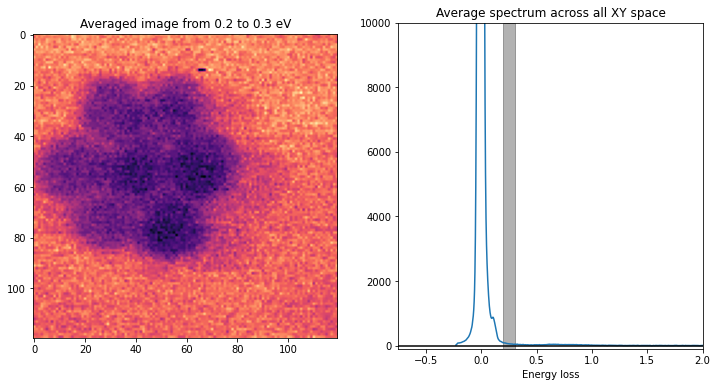

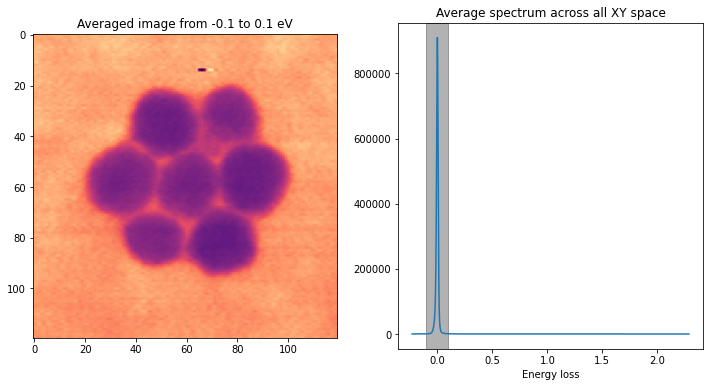

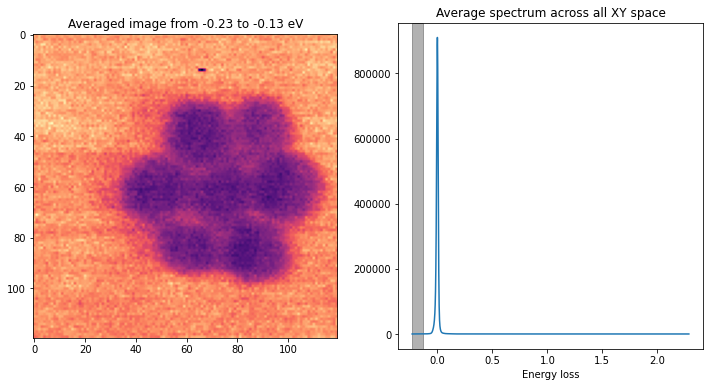

In [7]:
ii = 0

E1, E2 = 0.2, 0.3      # select energy range (in eV) to display
i1, i2 = (np.abs(E_list[ii]-E1)).argmin(), (np.abs(E_list[ii]-E2)).argmin()

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(np.mean(SI_list[ii][:,:,i1:i2],axis=2), cmap = 'magma')
ax[1].plot(E_list[ii], np.mean(SI_list[ii][:,:,:],axis=(0,1)))

# Other plotting details
ax[0].set_title("Averaged image from {} to {} eV".format(E1,E2))
ax[1].set_title("Average spectrum across all XY space")
ax[1].set_xlabel("Energy loss")
ax[1].axhline(0,c='k')
ax[1].axvspan(E1,E2,color='k',alpha=0.3)
ax[1].set_xlim(-0.75,2)
ax[1].set_ylim(-100,10000)

#############################
E1, E2 = -0.1, 0.1     # select energy range (in eV) to display

i1, i2 = (np.abs(E_list[ii]-E1)).argmin(), (np.abs(E_list[ii]-E2)).argmin()
Eslice = np.mean(SI_list[ii][:,:,i1:i2],axis=2)

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(Eslice, cmap = 'magma')
ax[1].plot(E_list[ii], np.mean(SI_list[ii][:,:,:],axis=(0,1)))
ax[1].axvspan(E1,E2,color='k',alpha=0.3)
ax[0].set_title("Averaged image from {} to {} eV".format(E1,E2))
ax[1].set_title("Average spectrum across all XY space")
ax[1].set_xlabel("Energy loss")
##############################

E1, E2 = E_list[ii].min(), E_list[ii].min()+0.1     # select energy range (in eV) to display

i1, i2 = (np.abs(E_list[ii]-E1)).argmin(), (np.abs(E_list[ii]-E2)).argmin()
Eslice = np.mean(SI_list[ii][:,:,i1:i2],axis=2)

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(Eslice, cmap = 'magma')
ax[1].plot(E_list[ii], np.mean(SI_list[ii][:,:,:],axis=(0,1)))
ax[1].axvspan(E1,E2,color='k',alpha=0.3)
ax[0].set_title("Averaged image from {} to {} eV".format(np.round(E1,2),np.round(E2,2)))
ax[1].set_title("Average spectrum across all XY space")
ax[1].set_xlabel("Energy loss")

E1,E2

* The group of particles should be located at the CENTER of the field of view (and NOT move when selecting different energy regions!)
* This is the nature of the so-called bumponium effect

# Object tracking

* First step is to construct a "movie" from several energy slices (image stack).
* We can specify the <b><font color='crimson'>energy slice width</font></b>, and the <b><font color='crimson'>energy step size</font></b> for subsequent frames
* Then we need an object tracking scheme, and a "ground truth" - which is easy because main ZLP is a ground truth for the object.

## 1. Create "movie" frames

* Define <b>energy slice width</b> - I think 0.050 eV is plenty small enough (too small and it likely becomes too noisy)
* Define <b>energy step size</b> - I think 0.005 or 0.010 eV is plenty small for step size, can increase this a lot if needed.
* Define upper limit to energy slicing (<b>Emax</b>) --> this should be slightly more than 0 eV, around 0.050 is OK I think. If want to me ultraconservative, set to 0
* We should START with the lowest energy available as a starting point (GAIN side of the ZLP)

In [23]:
###################################
######### USER PARAMETERS #########
###################################
k = 0 # select the dataset

slice_width = 0.050 
slice_step = 0.005
Emax = 0.05  # we want to stay on the "gain side" of the ZLP (everything negative of the ZLP), but we can go slightly positive. 50 meV is OK I think
####################################

Energy_axis = E_list[k]
spec_im = SI_list[k]

E0 = E_list[k].min()  # minimum is lowest energy detected
E1 = E0+slice_width 

num_frames = int(np.floor((Emax - E1)/slice_step))+1
E_slices = np.zeros((num_frames,2))

for ii in range(len(E_slices)):
  E_slices[ii,0] = E0 + ii*slice_step
  E_slices[ii,1] = E1 + ii*slice_step

# Then convert real energy to closest channel number

channel_slices = np.zeros((num_frames,2))
for ii in range(len(channel_slices)):
  channel_slices[ii,0] = (np.abs(Energy_axis-E_slices[ii,0])).argmin()
  channel_slices[ii,1] = (np.abs(Energy_axis-E_slices[ii,1])).argmin()
channel_slices = channel_slices.astype(int)

# create individual frames for each channel slice pair
Frames = np.zeros((num_frames,spec_im.shape[0], spec_im.shape[1]))

for jj in range(len(Frames)):
  Frames[jj] = np.mean(spec_im[:,:,channel_slices[jj,0]:channel_slices[jj,1]],axis=2)

Frames = np.flip(Frames,axis=0)

# normalize each frame [0,1] and invert intensity so that particles/objects are high (1) and background is low (0)
for ii in range(len(Frames)):
  Frames[ii] = (Frames[ii] - np.min(Frames[ii]))/np.ptp(Frames[ii])
  Frames[ii] = 1-Frames[ii]

View the frames:
* We can say that the 3D data cube in X,Y,E becomes X,Y,T where T is some discrete values of time.

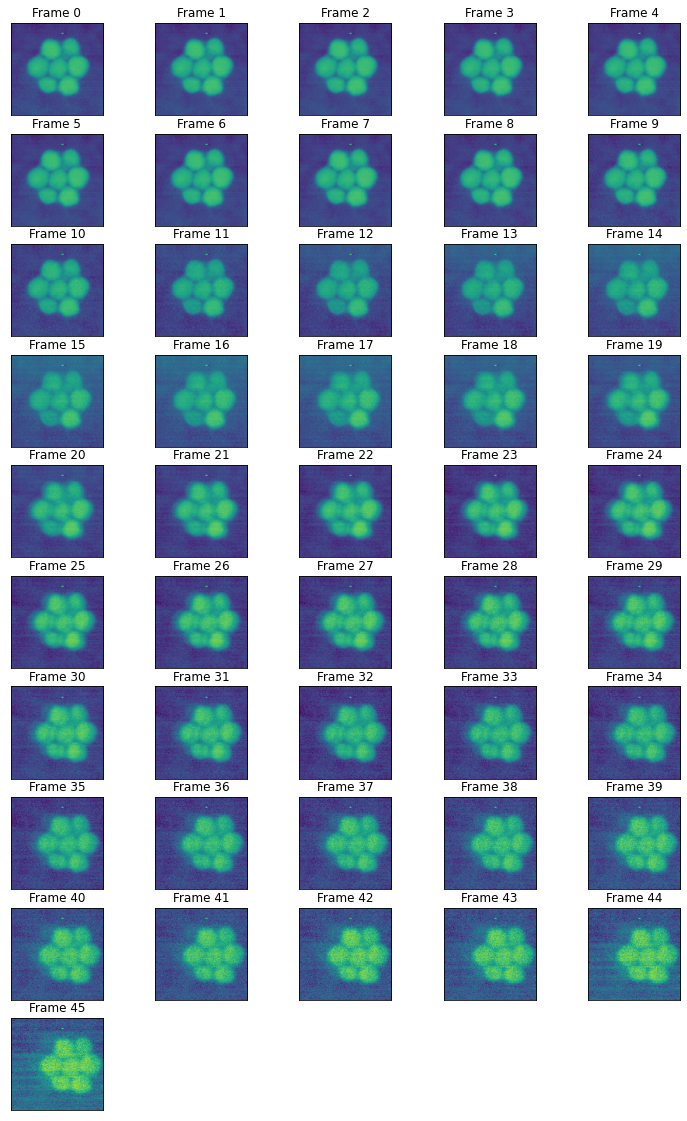

In [24]:
cols = 5
rows = int(len(Frames)/cols + 1)

fig = plt.figure(figsize=(2.5*cols,2*rows))
gs = gridspec.GridSpec(rows, cols)

for i in range(len(Frames)):
    ax = fig.add_subplot(gs[i])
    ax.imshow(Frames[i])
    ax.set_title('Frame {}'.format(i))
    plt.setp([ax],xticks=[], yticks=[])

## 2. Object track each frame

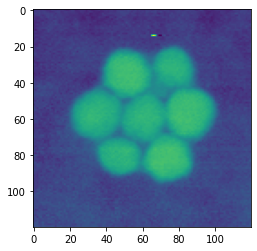

In [25]:
# We have a ground truth object that we want tracked, this is essentially frame 0:

ground_truth = Frames[0]
plt.imshow(ground_truth)

* These are quite well defined particles (reasonable resolution 2D view), so let's use an easy method: Laplacian of Gaussian (LoG)

In [26]:
from skimage.feature import blob_log

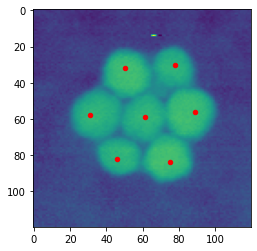

In [27]:
# Adjust the blob finding parameters
# mainly min and max sigma (related to particle size) and threshold (intensity)

image = ground_truth
blobs = blob_log(image, min_sigma=4, max_sigma=10, num_sigma=10, threshold=0.05)

plt.imshow(image)
plt.scatter(blobs[:,1], blobs[:,0], c='r', s = 20)

Repeat this for all frames, gather all coordinates, create a vector for each blob

In [28]:
blobs_all = np.zeros((len(Frames),blobs.shape[0], blobs.shape[1]))

for ii in range(len(blobs_all)):
  blobs_all[ii] = blob_log(Frames[ii],min_sigma=4, max_sigma=10, num_sigma=10, threshold=0.05)

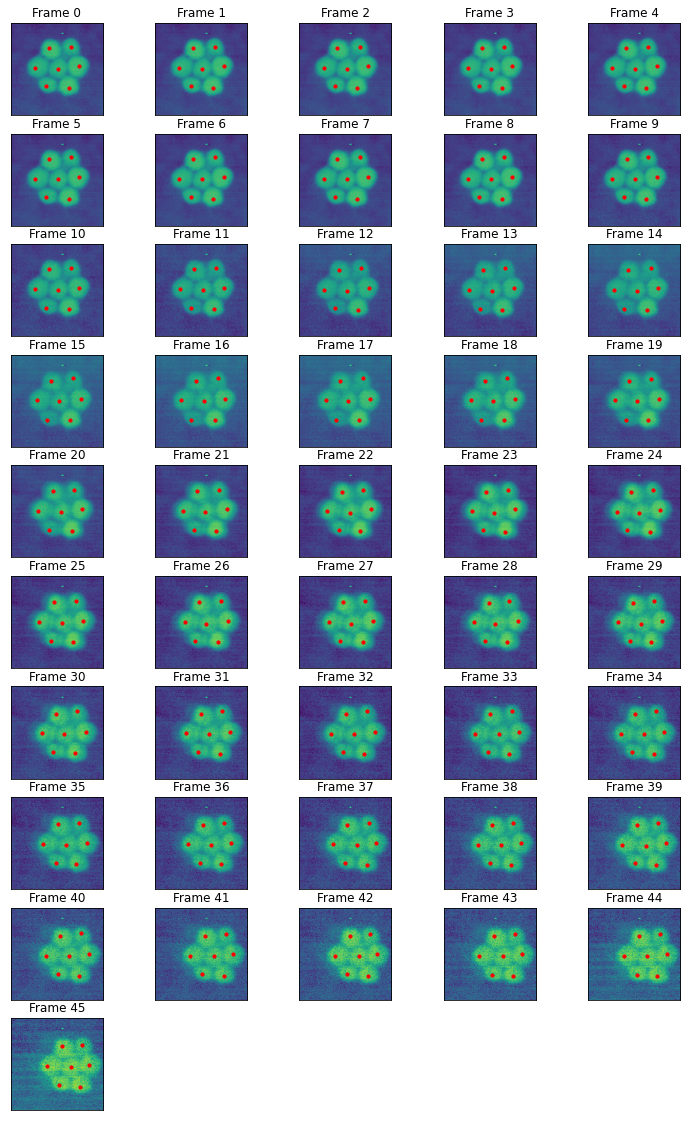

In [29]:
cols = 5
rows = int(len(Frames)/cols + 1)

fig = plt.figure(figsize=(2.5*cols,2*rows))
gs = gridspec.GridSpec(rows, cols)

for i in range(len(Frames)):
    ax = fig.add_subplot(gs[i])
    ax.imshow(Frames[i])
    ax.scatter(blobs_all[i][:,1], blobs_all[i][:,0], c='r', s=10)
    ax.set_title('Frame {}'.format(i))
    plt.setp([ax],xticks=[], yticks=[])

In [30]:
blobs_all.shape

(46, 7, 3)

Analyze each particle's (blob's) trajectory:

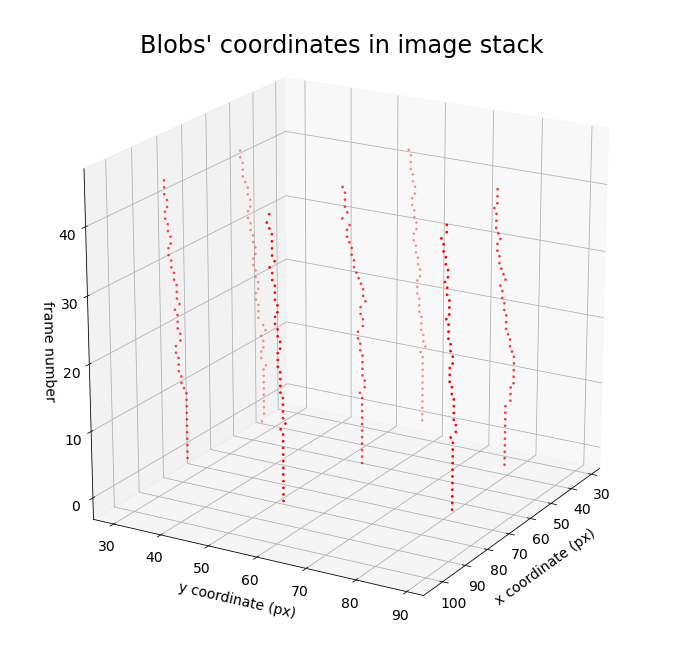

In [31]:
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(20, 30)
ax.set_xlabel('x coordinate (px)', fontsize=14)
ax.set_ylabel('y coordinate (px)', fontsize=14)
ax.set_zlabel('frame number', fontsize=14)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 5
ax.set_title("Blobs' coordinates in image stack", fontsize=24)
ax.dist = 10 # use it to zoom in/out
for k in range(blobs_all.shape[0]):
    ax.scatter(blobs_all[k,:,1], blobs_all[k,:,0], k, c='r', s=3)
ax.tick_params(labelsize=14)

Let's track one particle first:

In [43]:
# Let's start analysis with blob #0:
blobs_all[:,0,:].shape

# Here, there are 46 different coordinates for blob 1, 
# therefore, there are 45 vectors for blob 1 in this case 
# (as there are also for each of the other blobs)

(46, 3)

In [42]:
blob_shifts_0 = np.zeros((blobs_all[:,0,:].shape[0]-1, 2)) # Should be one less, and 2 for x and y

# for blob #0, blobs_all[x,0,x] --> 0 is the second argument
for kk in range(len(blob_shifts_0)):
  blob_shifts_0[kk,0] = blobs_all[kk,0,1] - blobs_all[kk+1,0,1]
  blob_shifts_0[kk,1] = blobs_all[kk,0,0] - blobs_all[kk+1,0,0]

average0 = np.sum(blob_shifts_0,axis=0) 
print("TOTAL movement across full image stack for blob 0: {}".format(average0))

TOTAL movement across full image stack for blob 0: [-15.  -5.]


Repeat for all blobs
* We can get an average vector (assuming linearity), or vectors between each frame --> this will depend on our energy step size we have chosen in the beginning (currently set to 0.005 eV, which is quite small step size)

In [37]:
blob_shifts_all = np.zeros((blobs_all.shape[1],blobs_all[:,0,:].shape[0]-1, 2))

for ii in range(blobs_all.shape[1]):
  for kk in range(blob_shifts_all.shape[1]):
    blob_shifts_all[ii,kk,0] = blobs_all[kk,ii,1] - blobs_all[kk+1,ii,1]
    blob_shifts_all[ii,kk,1] = blobs_all[kk,ii,0] - blobs_all[kk+1,ii,0]

averages = np.zeros((blobs_all.shape[1], 2))

for k in range(len(averages)):
  averages[k] = np.sum(blob_shifts_all[k],axis=0)

averages

array([[-15.,  -5.],
       [-17.,  -5.],
       [-17.,  -4.],
       [-16.,  -4.],
       [-13.,  -4.],
       [-16.,  -4.],
       [-15.,  -4.]])

* "Averages" are the average vectors for each of the particles.
* blob_shifts_all contains the particle motion for each discrete step, however, a caviat to choosing a small energy step size is that the blob positions are NOT to sub-pixel accuracy. In other words, if the particle moves less than a pixel (but still moves), it might be recorded as moving zero distance, or one pixel (in x or y, for example)
* To get around this, one can increase energy step size, or, artificially upscale each frame in the "movie" to a higher pixel density, say, 5 or 10x larger in each X and Y dimension, do the blob finding with LoG again, and then divide by the upscale factor to get subpixel accuracy

____
* It probably makes sense to average all the averages (probably smooths noise) so that we have a **single** vector for the entire shadow
* Note this vector might need to be negated depending on frame of reference

In [40]:
all_blobs_average  = np.mean(averages,axis=0)
print(all_blobs_average)

[-15.57142857  -4.28571429]
